In [8]:
import sklearn.preprocessing as skp
import sklearn.model_selection as ms
import sklearn.metrics as sx
import sklearn.linear_model as skl
from sklearn import ensemble
from sklearn import feature_selection as skf
from sklearn import pipeline as pp
import pandas as pd
import numpy as np
import pylab as pl
import bz2

In [233]:
df = pd.read_csv("./features.csv", index_col='match_id')
df_holdout = pd.read_csv("./features_test.csv", index_col='match_id')

`1.` Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [234]:
target_cols = [c for c in df.columns if c not in df_holdout.columns ]
feature_cols = [c for c in df.columns if c in df_holdout.columns ]
print("Target columns are: %s \n" % target_cols)
print("First 10 feature columns are: %s ...\n" % feature_cols[:10])

Target columns are: ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'] 

First 10 feature columns are: ['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items'] ...



We're going to separate target and feature columns using `target_cols` and `feature_cols` lists

---

`2.`Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [235]:
counts = df.count()
features_with_missing = counts[counts < counts.max()].index
print("Название фичей, которые имеют  пропуски: %s " % features_with_missing)

Название фичей, которые имеют  пропуски: Index(['first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time',
       'radiant_flying_courier_time', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_first_ward_time'],
      dtype='object') 


In [236]:
df.loc[pd.isna(df.first_blood_time),['first_blood_time', 'first_blood_team'] + target_cols].head(5)

,first_blood_time,first_blood_team,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,
3,NaN,NaN,1459,0,1920,2047,50,63
9,NaN,NaN,4079,1,1540,0,63,0
45,NaN,NaN,2338,0,1542,1972,51,63
51,NaN,NaN,3419,0,0,1792,0,48
86,NaN,NaN,3588,1,1844,0,63,0


Рассмотрим пропуски в полях `'first_blood_time', 'first_blood_team'` - наличие пропуска в каком либо из полей означет что не было сделано ни одного 'фрага' за все время игры. То есть никакие герои не были убиты и отправлены в таверну.

При этом видно, вто таргет переменные об ихсоде матча присутствуют и есть иничего не рашесходный результат матча.

Можно сделать вывод что происходил один из двух сценариев:

1. Одна из команд просто отсиживалась на базе, пока вторая просто ломала башни и трон.
   Например это мог быть ничего не решающий или договорной матч.
   Это происходит barracks_status одной из команд нулевой. 
   
2. Либо обе команды ломали бараки друг другу, по разным направлениям, не отвлекаясь на 
   дуэли героев. Это происходит, когда значения tower_status или barracks_status не 
   нулевые у обоих команд.

---

`3.` Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [237]:
df = df.fillna(0)
df_holdout = df_holdout.fillna(0)

---

`4.` Какой столбец содержит целевую переменную? Запишите его название.

In [238]:
y_col = 'radiant_win'

---

`5.` Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [239]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [240]:
X = df.loc[:, feature_cols].copy()
y = df.loc[:, y_col].copy()

Базовая версия Градиентного бустинга на 30 естиматорах

In [241]:
%%time
base_roc_aucs = ms.cross_val_score(ensemble.GradientBoostingClassifier(n_estimators=30), X, y, scoring='roc_auc',
                   cv = ms.KFold(n_splits=5, shuffle=True), n_jobs=4)

CPU times: user 944 ms, sys: 172 ms, total: 1.12 s
Wall time: 28.4 s


In [243]:
np.mean(base_roc_aucs)

0.6894046983162839

##### Базовая версия Градиентного бустинга на 30 естиматорах, заняля 29.1 c на 4х процессорах

##### Средний roc_auc: 0.6894

осуществим поиск оптимального количество классификаторов

In [108]:
def xgb_set():
    base_cl = ensemble.GradientBoostingClassifier()
    grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
    return base_cl, grid

In [109]:
%%time
base_cl, param_grid = xgb_set()
cl_grid  = ms.GridSearchCV(base_cl, param_grid, cv = ms.KFold(n_splits=5, shuffle=True),
                           scoring='roc_auc', refit=True, n_jobs=8)
cl_grid.fit(X, y)

CPU times: user 1min 4s, sys: 324 ms, total: 1min 5s
Wall time: 4min 27s


In [192]:
fi = pd.Series(index=X.columns, data=cl_grid.best_estimator_.feature_importances_)

In [197]:
print("Top 10 feature importances according to XGB")
fi.sort_values(ascending=False)[:10]

Top 10 feature importances according to XGB


d2_gold    0.074773
d5_gold    0.073498
d1_gold    0.070968
d4_gold    0.070331
r2_gold    0.069308
r1_gold    0.068161
r3_gold    0.064302
r4_gold    0.061345
r5_gold    0.060972
d3_gold    0.060448
dtype: float64

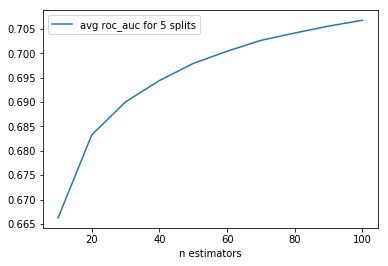

In [126]:
plot_y = cl_grid.cv_results_['mean_test_score']
plot_x = [p['n_estimators']for p in cl_grid.cv_results_['params']]
pl.plot(plot_x, plot_y, label='avg roc_auc for 5 splits')
pl.xlabel('n estimators')
pl.legend()
pass

##### Базовая версия Градиентного бустинга на сетке  поиска заняла 4min 27s на 8ми процессорах

##### Лучший средний roc_auc получен на 100 естиматорах: 0.70675 

Да - имеет смысл повышать количество эстиматоров

В качестве убыстрения можно начать работать с сэмплами или пробовать укоротить глубину деревьев

---

### Логистическая регресиия

`1.`

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [244]:
def logreg_set():
    base_cl = skl.LogisticRegression(penalty='l2')
    grid = {'C': np.power(10., np.arange(-5, 4, 1))}
    return base_cl, grid

In [245]:
X = df.loc[:, feature_cols].copy()
y = df.loc[:, y_col].copy()

In [246]:
%%time
base_cl, param_grid = logreg_set()
lr_pipeline = pp.Pipeline(steps =[
 ('standard_scaler', skp.StandardScaler()),
 ('grid_search', ms.GridSearchCV(base_cl, param_grid, cv = ms.KFold(n_splits=5, shuffle=True),
                           scoring='roc_auc', refit=True, n_jobs=4))
])
lr_pipeline.fit(X, y)

CPU times: user 11.5 s, sys: 444 ms, total: 12 s
Wall time: 52.3 s


In [248]:
lr_pipeline.named_steps['grid_search'].best_params_,\
lr_pipeline.named_steps['grid_search'].best_score_

({'C': 0.01}, 0.716461419269333)

- Логистическая регрессия обучается на много быстрее градиентного бустина, из за более простой схемы оптимизации целевой функции

- Наилучшие метрики полученные на l2 регуляризации при C = 0.01
  
  roc_auc: 0.71646
  
  Это превосходит метрики градиентного бустинга даже при числе классификаторов 100
  
- Если в пространстве признаков значения хорошо отделимы одной гиперплоскостью, то логистическая регресия будет работать лучше градиентного бустинга - для которого линейно разделимые пространства более сложная зажадача чем для линейной регрессии. Видимо данных датасет обладает именно таким свойством

---

`2.` Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [249]:
cat_feature_cols = [c for c in df.columns if c.endswith('_hero')] + ['lobby_type'] 
cat_feature_cols

['r1_hero',
 'r2_hero',
 'r3_hero',
 'r4_hero',
 'r5_hero',
 'd1_hero',
 'd2_hero',
 'd3_hero',
 'd4_hero',
 'd5_hero',
 'lobby_type']

In [250]:
cat_free_cols = list(set.difference(set(feature_cols), set(cat_feature_cols)))
X_cat_free = df.loc[:, cat_feature_cols].copy()
y = df.loc[:, y_col].copy()

In [251]:
%%time
base_cl, param_grid = logreg_set()
lr_pipeline_2 = pp.Pipeline(steps =[
 ('standard_scaler', skp.StandardScaler()),
 ('grid_search', ms.GridSearchCV(base_cl, param_grid, cv = ms.KFold(n_splits=5, shuffle=True),
                           scoring='roc_auc', refit=True, n_jobs=4))
])
lr_pipeline_2.fit(X_cat_free, y)

CPU times: user 1.18 s, sys: 136 ms, total: 1.31 s
Wall time: 3.98 s


In [252]:
lr_pipeline_2.named_steps['grid_search'].best_params_,\
lr_pipeline_2.named_steps['grid_search'].best_score_

({'C': 1e-05}, 0.5052742819422704)

- Качество Логрегрессии упало до уровня случайного подкидываения монетки, то есть roc-auc = 0.5 

- Очевидно данные категориальные признаки являются самыми ключевыми для принятия решения

---

`3.` На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts)

In [255]:
hero_cols = [c for c in cat_feature_cols if c != 'lobby_type']
hero_ids = np.unique(np.ravel(df.loc[:, hero_cols].values))

In [260]:
len(hero_ids)

108

- В датасете было замечено 108 различных героев

- Герои пронумерованы числами от 1 до 112 есть пропуски,
например в датасете отсутствует герой с номером 107

- То есть можно сказать что всего есть 112 героев

---

`4.` Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [261]:
N = 112
X_pick = np.zeros((df.shape[0], N))
for i, match_id in enumerate(df.index):
    for p in range(5):
        X_pick[i, df.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, df.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [275]:
X_onehot = np.hstack([df.loc[:, cat_free_cols].values, X_pick])

`5.` Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [277]:
%%time
base_cl, param_grid = logreg_set()
lr_pipeline_3 = pp.Pipeline(steps =[
 ('standard_scaler', skp.StandardScaler()),
 ('grid_search', ms.GridSearchCV(base_cl, param_grid, cv = ms.KFold(n_splits=5, shuffle=True),
                           scoring='roc_auc', refit=True, n_jobs=4))
])
lr_pipeline_3.fit(X_onehot, y)

CPU times: user 20.9 s, sys: 696 ms, total: 21.6 s
Wall time: 1min 28s


In [278]:
lr_pipeline_3.named_steps['grid_search'].best_params_,\
lr_pipeline_3.named_steps['grid_search'].best_score_

({'C': 0.01}, 0.7519025832375034)

- Мешок слов дал позитивный прирост для roc_auc показателей лог регрессии
  и показал самый высокий результат
  
- One-hot обработка категориальных фичей очень распространена среди линейных можелей так как имеет свойство линеаризовывать пространство зависимостей

---

`6.` Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [284]:
N = 112
X_pick_ho = np.zeros((df_holdout.shape[0], N))
for i, match_id in enumerate(df_holdout.index):
    for p in range(5):
        X_pick_ho[i, df_holdout.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_ho[i, df_holdout.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [287]:
X_ho_onehot = np.hstack([df_holdout.loc[:, cat_free_cols].values, X_pick_ho])

In [290]:
pred = lr_pipeline_3.predict_proba(X_ho_onehot)[:,1]

In [301]:
"%.4f"  % min(pred), "%.4f"  %  max(pred)

('0.0085', '0.9963')

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


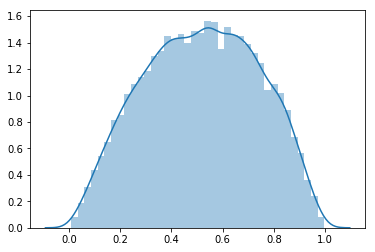

In [294]:
import seaborn as sns
sns.distplot(pred)
pass